In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import os, shutil, random
from pathlib import Path
from PIL import Image

In [5]:
# Source (your uploaded dataset)
SOURCE_DIR = "/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset"
# Output (where cleaned & split dataset will go)
OUTPUT_DIR = "/kaggle/working/tea-data"

# Train/val/test split ratio
SPLIT = (0.7, 0.15, 0.15)
SEED = 42
random.seed(SEED)

# Create output folders
for split in ["train", "val", "test"]:
    for cls in os.listdir(SOURCE_DIR):
        Path(os.path.join(OUTPUT_DIR, split, cls)).mkdir(parents=True, exist_ok=True)

# Loop through classes
for cls in os.listdir(SOURCE_DIR):
    class_path = os.path.join(SOURCE_DIR, cls)
    if not os.path.isdir(class_path):
        continue

    files = [f for f in os.listdir(class_path) if f.lower().endswith((".jpg", ".jpeg", ".png"))]

    # Verify images (remove corrupt)
    clean_files = []
    for f in files:
        img_path = os.path.join(class_path, f)
        try:
            img = Image.open(img_path)
            img.verify()
            clean_files.append(f)
        except Exception:
            print(f" Removed corrupt: {img_path}")

    # Shuffle and split
    random.shuffle(clean_files)
    n = len(clean_files)
    n_train = int(SPLIT[0] * n)
    n_val = int(SPLIT[1] * n)

    train_files = clean_files[:n_train]
    val_files = clean_files[n_train:n_train+n_val]
    test_files = clean_files[n_train+n_val:]

    # Copy to new dirs
    for f in train_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(OUTPUT_DIR, "train", cls, f))
    for f in val_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(OUTPUT_DIR, "val", cls, f))
    for f in test_files:
        shutil.copy(os.path.join(class_path, f), os.path.join(OUTPUT_DIR, "test", cls, f))

print(" Dataset cleaned and split. Ready at:", OUTPUT_DIR)


 Dataset cleaned and split. Ready at: /kaggle/working/tea-data


In [6]:
for split in ["train", "val", "test"]:
    for cls in os.listdir(os.path.join(OUTPUT_DIR, split)):
        count = len(os.listdir(os.path.join(OUTPUT_DIR, split, cls)))
        print(f"{split}/{cls}: {count} images")

train/Anthracnose: 70 images
train/bird eye spot: 70 images
train/red leaf spot: 100 images
train/gray light: 70 images
train/white spot: 99 images
train/healthy: 51 images
train/algal leaf: 79 images
train/brown blight: 79 images
val/Anthracnose: 15 images
val/bird eye spot: 15 images
val/red leaf spot: 21 images
val/gray light: 15 images
val/white spot: 21 images
val/healthy: 11 images
val/algal leaf: 16 images
val/brown blight: 16 images
test/Anthracnose: 15 images
test/bird eye spot: 15 images
test/red leaf spot: 22 images
test/gray light: 15 images
test/white spot: 22 images
test/healthy: 12 images
test/algal leaf: 18 images
test/brown blight: 18 images


In [7]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define image size & batch
IMG_SIZE = 224
BATCH_SIZE = 32

# Data transforms (augment train set)
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create datasets
data_dir = OUTPUT_DIR
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
                  for x in ["train", "val", "test"]}

# Create dataloaders
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
               for x in ["train", "val", "test"]}

# Class names
class_names = image_datasets["train"].classes
print("Classes:", class_names)
print("Train size:", len(image_datasets["train"]))
print("Val size:", len(image_datasets["val"]))
print("Test size:", len(image_datasets["test"]))


Classes: ['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']
Train size: 618
Val size: 130
Test size: 137


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import copy
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# ===== CONFIG =====
EPOCHS = 30
LEARNING_RATE = 1e-4
PATIENCE = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/kaggle/working/best_model.pth"
SPECIAL_MODEL_PATH = "/kaggle/working/special_model_95.pth"
# ==================

# 🔹 Model (ConvNeXt-Tiny transfer learning)
model = models.convnext_tiny(pretrained=True)
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, len(class_names))  # replace last FC layer
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
best_loss = np.inf
epochs_no_improve = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 30)

    for phase in ["train", "val"]:
        if phase == "train":
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == "train":
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == "val":
            scheduler.step(epoch_loss)

            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), MODEL_PATH)
                print("  Saved new best model")

            if epoch_acc > 0.95:
                torch.save(model.state_dict(), SPECIAL_MODEL_PATH)
                print("  Validation acc > 95%! Model saved separately.")

            if epoch_loss < best_loss:
                epochs_no_improve = 0
                best_loss = epoch_loss
            else:
                epochs_no_improve += 1
                print(f"  No improvement for {epochs_no_improve} epochs")
                if epochs_no_improve >= PATIENCE:
                    print("  Early stopping triggered!")
                    model.load_state_dict(best_model_wts)
                    break

    else:
        continue
    break

# Load best weights
model.load_state_dict(best_model_wts)
print(f"\nTraining complete. Best val Acc: {best_acc:.4f}")


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 201MB/s]  



Epoch 1/30
------------------------------
train Loss: 1.3669 Acc: 0.5340
val Loss: 0.6605 Acc: 0.8385
  Saved new best model
  No improvement for 1 epochs

Epoch 2/30
------------------------------
train Loss: 0.5105 Acc: 0.8366
val Loss: 0.3421 Acc: 0.8846
  Saved new best model
  No improvement for 2 epochs

Epoch 3/30
------------------------------
train Loss: 0.3217 Acc: 0.8997
val Loss: 0.2862 Acc: 0.9077
  Saved new best model
  No improvement for 3 epochs

Epoch 4/30
------------------------------
train Loss: 0.1867 Acc: 0.9466
val Loss: 0.2269 Acc: 0.9462
  Saved new best model
  No improvement for 4 epochs

Epoch 5/30
------------------------------
train Loss: 0.0906 Acc: 0.9871
val Loss: 0.2574 Acc: 0.9231
  No improvement for 5 epochs
  Early stopping triggered!

Training complete. Best val Acc: 0.9462



📊 Classification Report:
               precision    recall  f1-score   support

  Anthracnose       0.91      0.67      0.77        15
   algal leaf       1.00      0.89      0.94        18
bird eye spot       0.73      0.73      0.73        15
 brown blight       0.94      0.94      0.94        18
   gray light       0.79      1.00      0.88        15
      healthy       1.00      1.00      1.00        12
red leaf spot       1.00      1.00      1.00        22
   white spot       0.88      0.95      0.91        22

     accuracy                           0.91       137
    macro avg       0.91      0.90      0.90       137
 weighted avg       0.91      0.91      0.90       137



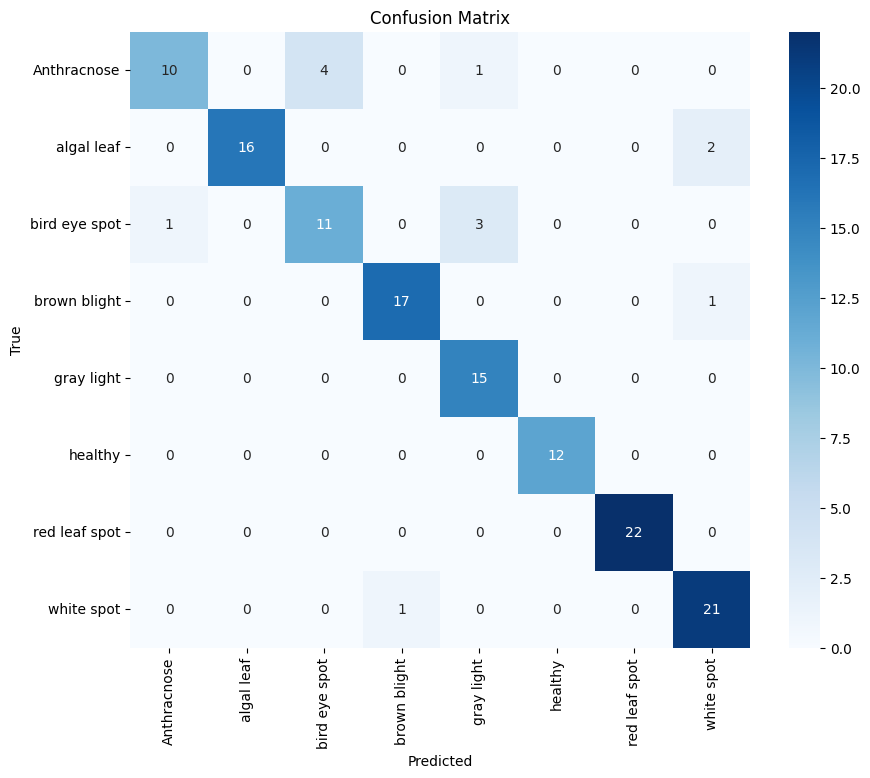

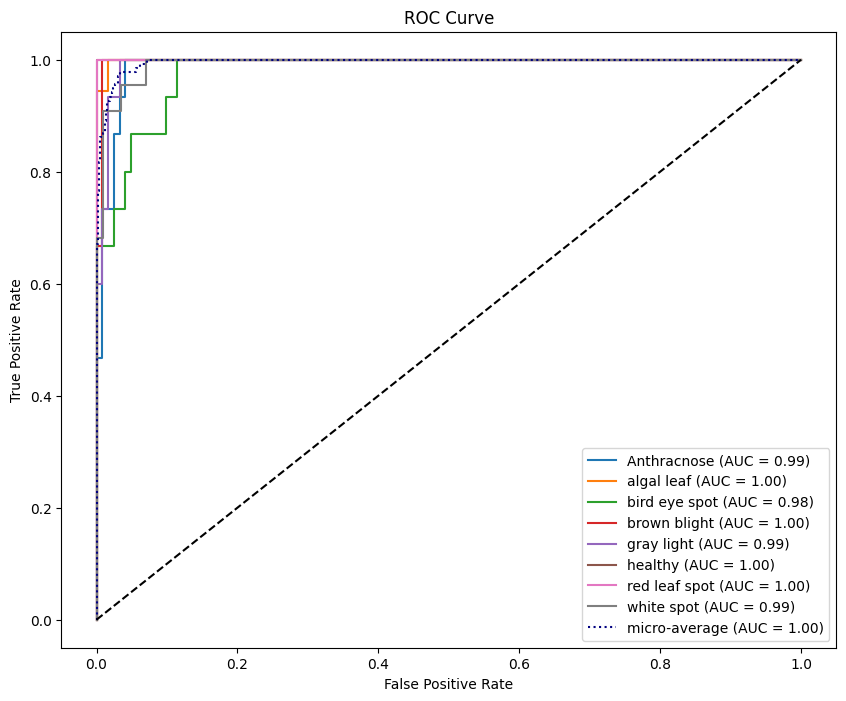

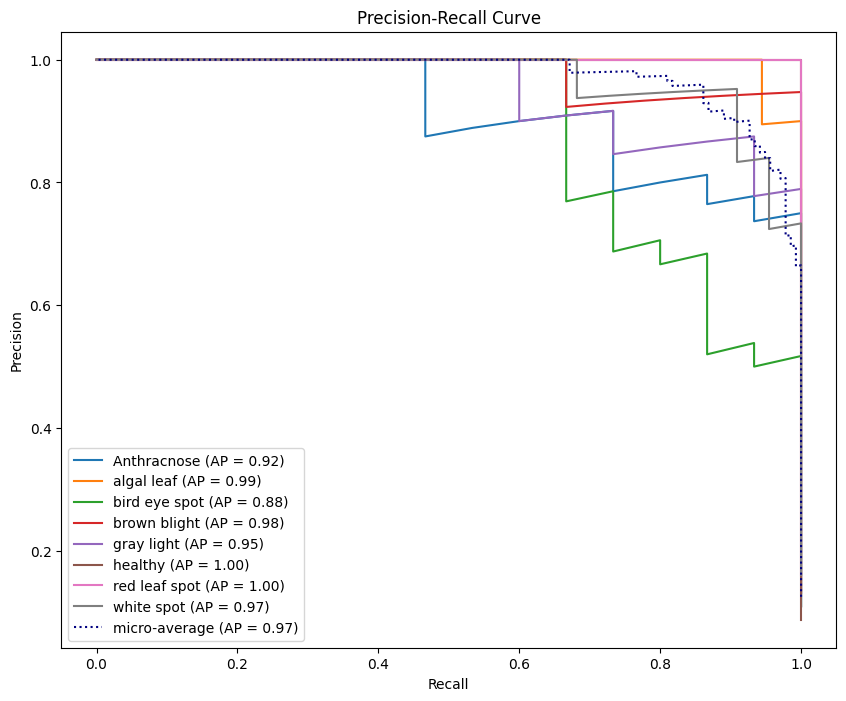

In [9]:
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score,
    precision_recall_curve, average_precision_score
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

# Reload best model
model.load_state_dict(torch.load(MODEL_PATH))
model.eval()

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for inputs, labels in dataloaders["test"]:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # get probabilities
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ===== Classification Report =====
print("\n📊 Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# ===== Confusion Matrix =====
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ===== ROC Curve (per class + macro/micro) =====
n_classes = len(class_names)
y_true_bin = label_binarize(all_labels, classes=list(range(n_classes)))

# Compute ROC curve and ROC area for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), all_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot(fpr["micro"], tpr["micro"], label=f"micro-average (AUC = {roc_auc['micro']:.2f})", color="navy", linestyle=":")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# ===== Precision-Recall Curve (per class + micro) =====
precision, recall, pr_auc = {}, {}, {}
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], all_probs[:, i])
    pr_auc[i] = average_precision_score(y_true_bin[:, i], all_probs[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(y_true_bin.ravel(), all_probs.ravel())
pr_auc["micro"] = average_precision_score(y_true_bin, all_probs, average="micro")

plt.figure(figsize=(10,8))
for i in range(n_classes):
    plt.plot(recall[i], precision[i], label=f"{class_names[i]} (AP = {pr_auc[i]:.2f})")
plt.plot(recall["micro"], precision["micro"], label=f"micro-average (AP = {pr_auc['micro']:.2f})", color="navy", linestyle=":")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()


In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms

def predict_with_gradcam(img_path, model, class_names, device):
    model.eval()
    
    # ---- Target layer (last Conv2d) ----
    target_layer = dict(model.named_modules())["features.7.2.block.0"]
    print(" Hooking into layer:", target_layer)

    activations = []
    gradients = []

    def forward_hook(module, inp, out):
        activations.append(out.detach())

    def backward_hook(module, grad_in, grad_out):
        gradients.append(grad_out[0].detach())

    fwd_hook = target_layer.register_forward_hook(forward_hook)
    bwd_hook = target_layer.register_full_backward_hook(backward_hook)

    # ---- Preprocess image ----
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
    ])
    img = Image.open(img_path).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)

    # ---- Forward pass ----
    outputs = model(input_tensor)
    pred_class = outputs.argmax(dim=1).item()

    # ---- Backward for Grad-CAM ----
    model.zero_grad()
    outputs[0, pred_class].backward()

    # ---- Extract hooks ----
    acts = activations[0].squeeze(0).cpu().numpy()  # (C,H,W)
    grads = gradients[0].squeeze(0).cpu().numpy()   # (C,H,W)

    weights = grads.mean(axis=(1,2))               # (C,)
    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    # ---- Normalize heatmap ----
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (224,224))
    cam = cam - cam.min()
    cam = cam / cam.max()

    # ---- Overlay heatmap ----
    img_np = np.array(img.resize((224,224)))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.5, heatmap, 0.5, 0)

    # ---- Plot ----
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title(f"Prediction: {class_names[pred_class]}")
    plt.imshow(img_np)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title("Grad-CAM")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()

    fwd_hook.remove()
    bwd_hook.remove()

    return class_names[pred_class]


 Hooking into layer: Conv2d(768, 768, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=768)


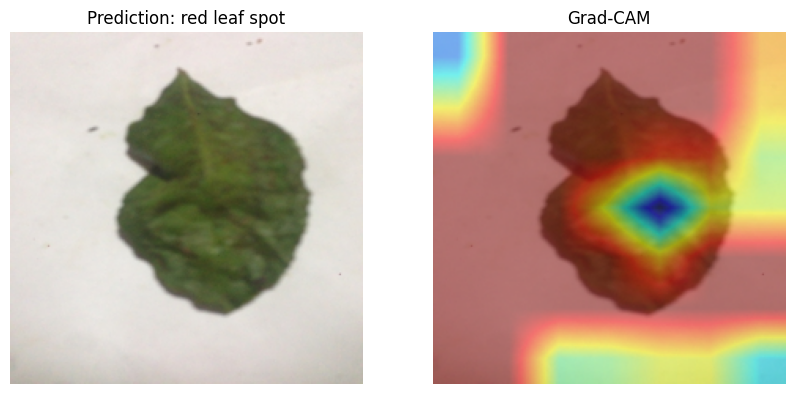

 Predicted class: red leaf spot


In [41]:
img_path = "/kaggle/input/identifying-disease-in-tea-leafs/tea sickness dataset/red leaf spot/UNADJUSTEDNONRAW_thumb_180.jpg"

predicted_class = predict_with_gradcam(img_path, model, class_names, device=DEVICE)
print(f" Predicted class: {predicted_class}")
